In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
import pandas as pd
import ampiimts
import time
import os 

In [2]:
#import files
folder = '../../dataset/pollution'
pds = []
with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))
len(pds)

61

In [ ]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=False)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Most frequent window size after 5 runs (all dfs): 168h


/home/guillaume/swt_package/.env_swt/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/guillaume/swt_package/.env_swt/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/guillaume/swt_package/.env_swt/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/guillaume/swt_package/.env_swt/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the e

AttributeError: module 'ampiimts' has no attribute 'plot_matrix_profiles_heatmap'

In [ ]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=True)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


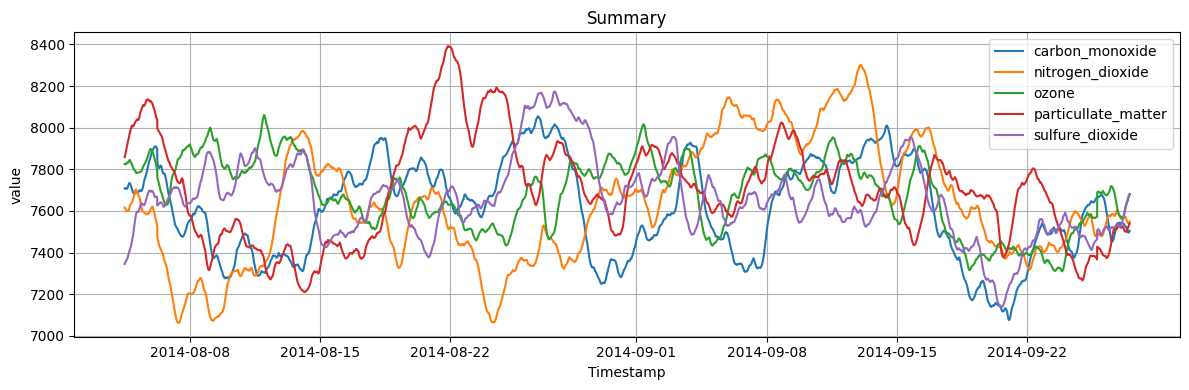

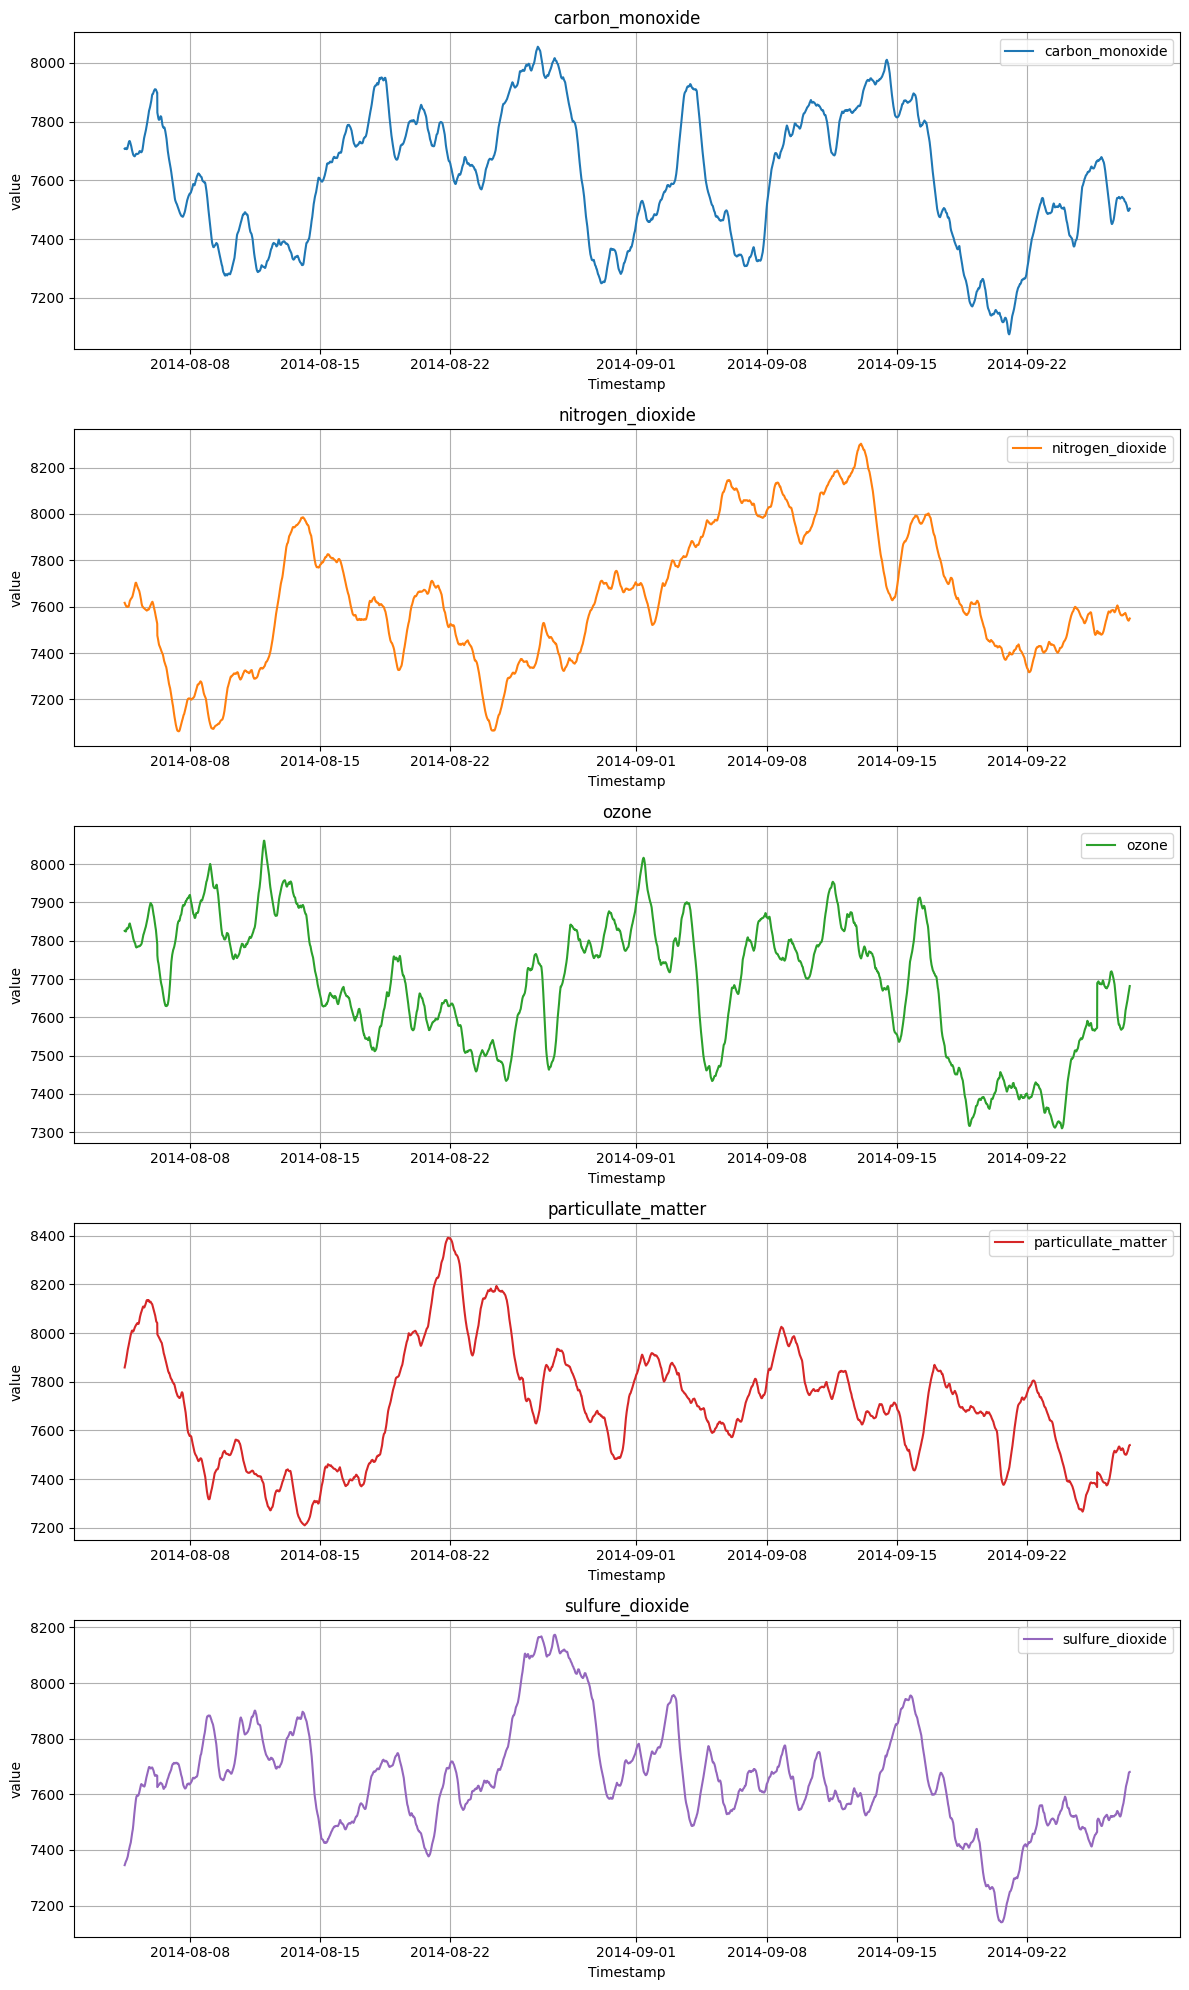

In [ ]:
# ampiimts.plot_multiple_dfs([matrix_profiles[0],matrix_profiles[1],matrix_profiles[2],matrix_profiles[3],matrix_profiles[4]], labels=['carbon_monoxide', 'nitrogen_dioxide', 'ozone', 'particullate_matter', 'sulfure_dioxide'],  column='value')
